In [75]:
import pandas as pd

# Step 1: Scraping

## Collect coke price data

In [76]:
coke_url = "https://www.numbeo.com/cost-of-living/prices_by_country.jsp?displayCurrency=USD&itemId=6"

In [77]:
tables = pd.read_html(coke_url)
coke_df = tables[1]
coke_df.head(2)

,Rank,Country,Coke/Pepsi (0.33 liter bottle)
0,NaN,Kazakhstan,0.63
1,NaN,Portugal,1.51


In [78]:
coke_df = coke_df.drop(columns='Rank')


In [98]:
coke_df = coke_df.rename(columns={'Country': "country", 'Coke/Pepsi (0.33 liter bottle)': "price"})
coke_df.head()

,country,price
0,Kazakhstan,0.63
1,Portugal,1.51
2,Greece,1.92
3,Latvia,1.28
4,Iran,0.91


## Collect salary data

In [84]:
salary_url = "https://www.numbeo.com/cost-of-living/country_price_rankings?itemId=105"
salary_tables = pd.read_html(salary_url)
salary_df = salary_tables[1]
salary_df.head()

,0,1,2,3
0,1.0,Switzerland,NaN,"5,906.40 $"
1,2.0,Singapore,NaN,"4,933.86 $"
2,3.0,United States,NaN,"4,178.17 $"
3,4.0,Qatar,NaN,"3,991.72 $"
4,5.0,Iceland,NaN,"3,806.46 $"


In [100]:
salary_df = salary_df.drop(columns=[0,2])
salary_df = salary_df.rename(columns={1: "country", 3: "mo_salary"})
salary_df.head()

,country,mo_salary
0,Switzerland,"5,906.40 $"
1,Singapore,"4,933.86 $"
2,United States,"4,178.17 $"
3,Qatar,"3,991.72 $"
4,Iceland,"3,806.46 $"


In [149]:
# Import World Bank data

wb_df = pd.read_csv('daily-median-income.csv')
wb_df

,Entity,Code,Year,Median income or expenditure per day
0,Albania,ALB,1996,6.972102
1,Albania,ALB,2002,6.688141
2,Albania,ALB,2005,7.799790
3,Albania,ALB,2008,8.400199
4,Albania,ALB,2012,8.240384
...,...,...,...,...
2358,Zambia,ZMB,2010,1.353084
2359,Zambia,ZMB,2015,1.570981
2360,Zimbabwe,ZWE,2011,3.798868
2361,Zimbabwe,ZWE,2017,2.874558


In [155]:
# Select the most recent year
daily_df.sort_values('Year', inplace=True, ascending=False)
daily_df = daily_df.groupby(by=['Entity'], as_index=False).first()
daily_df

,Entity,Code,Year,Median income or expenditure per day
0,Albania,ALB,2019,13.077384
1,Algeria,DZA,2011,8.043640
2,Angola,AGO,2018,3.420551
3,Argentina - urban,None,2020,17.233385
4,Armenia,ARM,2020,6.624779
...,...,...,...,...
186,Vietnam,VNM,2018,10.921968
187,World,OWID_WRL,2019,7.560000
188,Yemen,YEM,2014,3.435718
189,Zambia,ZMB,2015,1.570981


# Step 2: Cleaning

## Cleaning country names

In [161]:
# Merging datasets
merged = pd.merge(coke_df, salary_df, how="left", on="country")
merged

,country,price,mo_salary
0,Kazakhstan,0.63,465.55 $
1,Portugal,1.51,"1,067.47 $"
2,Greece,1.92,882.92 $
3,Latvia,1.28,"1,025.87 $"
4,Iran,0.91,311.67 $
...,...,...,...
103,Denmark,3.48,"3,519.87 $"
104,Dominican Republic,0.91,370.11 $
105,Mexico,0.99,681.20 $
106,Montenegro,2.04,653.84 $


In [162]:
cleaned_df = merged.replace({'[$]':'',',':''},regex=True)

In [163]:
cleaned_df.head()

,country,price,mo_salary
0,Kazakhstan,0.63,465.55
1,Portugal,1.51,1067.47
2,Greece,1.92,882.92
3,Latvia,1.28,1025.87
4,Iran,0.91,311.67


In [164]:
cleaned_df['mo_salary']=cleaned_df['mo_salary'].astype(float)
cleaned_df['price']=cleaned_df['price'].astype(float)

# Step 3: Data Analysis

In [169]:
cleaned_df['bottle_per_day'] = cleaned_df['mo_salary']/21/cleaned_df['price']
cleaned_df['bottle_per_day'] = cleaned_df['bottle_per_day'].round()
cleaned_df.head()

,country,price,mo_salary,bottle_per_day
0,Kazakhstan,0.63,465.55,35.0
1,Portugal,1.51,1067.47,34.0
2,Greece,1.92,882.92,22.0
3,Latvia,1.28,1025.87,38.0
4,Iran,0.91,311.67,16.0


In [170]:
cleaned_df.sort_values(by=['bottle_per_day'], ascending=False).dropna().head(15)

,country,price,mo_salary,bottle_per_day
92,Qatar,1.04,3991.72,183.0
36,Kuwait,0.54,2078.94,183.0
43,United Arab Emirates,1.07,3558.21,158.0
82,Singapore,1.56,4933.86,151.0
14,Bahrain,0.71,2075.78,139.0
87,Saudi Arabia,0.75,1956.81,124.0
60,Oman,0.82,2082.76,121.0
56,Hong Kong (China),1.21,2833.77,112.0
73,Japan,1.14,2591.13,108.0
90,China,0.49,1103.53,107.0


In [171]:
cleaned_df.to_csv("merged.csv",index=False)

<AxesSubplot: ylabel='country'>

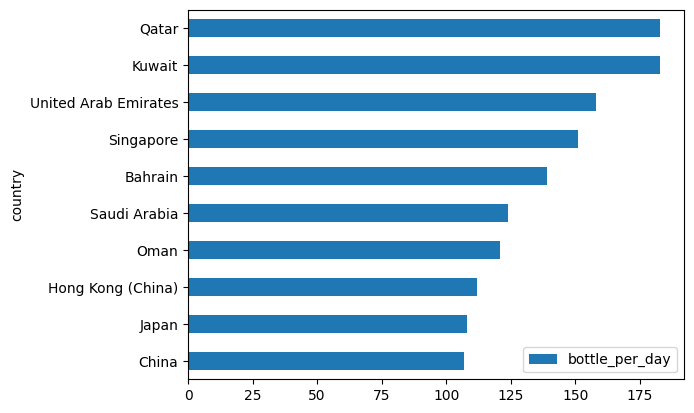

In [172]:
cleaned_df.sort_values(by='bottle_per_day').dropna().tail(10)\
    .plot(kind='barh',ylabel='country',y='bottle_per_day',x='country')